### Imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rc('image', cmap='RdBu_r')

In [2]:
import glob
import itertools as it
from collections import defaultdict
import yaml
import dill as pkl
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import networkx as nx
import seaborn
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

from data.dataset import GraphDataset, GraphDataModule
from model.model_module import GraphModelModule
from model.transformers import GraphAutoregTransformer, GraphRandomMaskedTransformer, EdgeSearchRandomMaskedTransformer
import utils.analysis, utils.load, utils.plot
from scripts.eval import model_eval

import wandb
import torch
import torch.nn.functional as F
from einops import rearrange, repeat

In [3]:
api = wandb.Api(timeout=19)
PROJECT = 'effie-li/graph-subgoal-v4'
runs, config_list, id_list = utils.load.fetch_runs(api, PROJECT)

def get_config(runid):
    return config_list[id_list.index(runid)]

### random mask model inference

In [4]:
import model.masked_iterative_inference as iterinf

In [22]:
# for runid in ['hfuz3w12', '2eogdrwq', '258zf14v', '13e7b8ig']: # human30
# for runid in ['1sbzhmry', '17lwle4y', '3hblx7rk', 'k5t3el7a']: # random50
# for runid in ['28qir0bf', 'fqww4ieg', '3aro8ucy', '3ufgfhr2']: # human30 (edgetoken)
for runid in ['2xzf7b0b', '1019r4sk', '2p0kzl0n', '1irz3l4a']: # random50 (edgetoken)

    # load model and val data
    config = get_config(runid)
    root = config['wandb']['save_dir'] + config['wandb']['project']
    model, datamodule, batch = utils.load.load_model_and_val_batch(
        config=config, ckpt_dir=f'{root}/{runid}/checkpoints', ckpt='last', val_batch='len4+'
    )
    batch_metadata = utils.analysis.generate_batch_metadata(dm=datamodule, batch=batch)
    assert type(model.transformer) in [GraphRandomMaskedTransformer, EdgeSearchRandomMaskedTransformer]
    model = model.transformer
    model.mask_all = True

    # get iterative generation acc
    out_dir = f'{root}/{runid}/'
    mode = 'max_negent'
    pred_nodes, pred_order, target_nodes, finished = iterinf.iterative_inference_loop(
        model, batch, sample_mode=mode, force_new_node=True, max_iter=10, debug_verbose=False
    )

    if sum(~finished) > 0:
        print(f'{runid} some seq prediction not finished w max_iter (not surprising if next node is sampled)')
        continue

    predictions = iterinf.pred_tensor_to_dict(pred_nodes, target_nodes, batch, datamodule)
    pkl.dump(predictions, open(f'{out_dir}/final_eval_{mode}.pkl', 'wb'))

    # get node prediction order
    acc_result = utils.analysis.accuracy_profile(
        predictions, batch, batch_metadata, verbose=False
    )
    correct = torch.tensor(list(acc_result['acc'].values())) == 1.0
    df = iterinf.pred_node_order_to_df(pred_nodes, pred_order, target_nodes, correct, batch, batch_metadata)
    df['iterative_mode'] = mode
    df['runid'] = runid
    df['model_type'] = 'random-masked'
    df.to_csv(f'{out_dir}/pred_order_{mode}.csv')

In [209]:
# pref score over checkpoints

for runid in ['hfuz3w12', '2eogdrwq', '258zf14v', '13e7b8ig']: # human30
# for runid in ['1sbzhmry', '17lwle4y', '3hblx7rk', 'k5t3el7a']: # random50
    print(runid)
    config = get_config(runid)
    root = config['wandb']['save_dir'] + config['wandb']['project']
    ckpts = utils.load.get_ckptfs_from_run(root, runid)
    init_ckpt = f'{root}/{runid}/checkpoints/init.ckpt'
    ckpts = pd.concat([pd.DataFrame({'epoch':[0], 'step':[0], 'fname':[init_ckpt]}), ckpts])

    val_batch = 'len4+'
    model, datamodule, batch = utils.load.load_model_and_val_batch(
        config=config, ckpt_dir=f'{root}/{runid}/checkpoints', ckpt='last', val_batch=val_batch
    )
    batch_metadata = utils.analysis.generate_batch_metadata(dm=datamodule, batch=batch)

    if os.path.exists(f'../figure/plot_data/v4/beh_results_{val_batch}_over_ckpts_{runid}.pkl'):
        beh_results_over_ckpts = pkl.load(open(f'../figure/plot_data/v4/beh_results_{val_batch}_over_ckpts_{runid}.pkl', 'rb'))
    else:
        beh_results_over_ckpts = defaultdict(list)

    for i, row in pd.concat([ckpts[:20], ckpts[20:200:18], ckpts[200::200]]).iterrows(): # human30
    # for i, row in pd.concat([ckpts[:120:6], ckpts[120:500:38], ckpts[500::500]]).iterrows(): # random50

        if row.step in beh_results_over_ckpts['step']: continue
        print(row.step, end=', ')
        beh_results_over_ckpts['step'].append(row.step)

        model = GraphModelModule.load_from_checkpoint(row.fname)
        _ = model.eval()

        # run max_negent inference
        model = model.transformer
        model.mask_all = True
        with torch.no_grad():
            pred_nodes, pred_order, target_nodes, finished = iterinf.iterative_inference_loop(
                model, batch, sample_mode='max_negent', force_new_node=True, max_iter=10, debug_verbose=False
            )

        predictions = iterinf.pred_tensor_to_dict(pred_nodes, target_nodes, batch, datamodule)

        acc_result = utils.analysis.accuracy_profile(predictions, batch, batch_metadata, verbose=False)
        pathpref_result = utils.analysis.path_preference(predictions, batch, batch_metadata, verbose=False)
        pathreg_result = utils.analysis.path_choice_regression(batch, model, predictions, batch_metadata=batch_metadata, 
                                                               path_score='avg', response='binary', verbose=False)
        result = acc_result | pathpref_result | pathreg_result
        for k in result:
            if k == 'acc': continue
            beh_results_over_ckpts[k].append(result[k])

        pkl.dump(beh_results_over_ckpts, open(f'../figure/plot_data/v4/beh_results_{val_batch}_over_ckpts_{runid}_max_negent.pkl', 'wb'))

hfuz3w12
0, 29, 59, 89, 119, 149, 179, 209, 239, 269, 299, 329, 359, 389, 419, 449, 479, 509, 539, 569, 599, 1139, 1679, 2219, 2759, 3299, 3839, 4379, 4919, 5459, 5999, 11999, 17999, 23999, 29999, 2eogdrwq
0, 29, 59, 89, 119, 149, 179, 209, 239, 269, 299, 329, 359, 389, 419, 449, 479, 509, 539, 569, 599, 1139, 1679, 2219, 2759, 3299, 3839, 4379, 4919, 5459, 5999, 11999, 17999, 23999, 29999, 258zf14v
0, 29, 59, 89, 119, 149, 179, 209, 239, 269, 299, 329, 359, 389, 419, 449, 479, 509, 539, 569, 599, 1139, 1679, 2219, 2759, 3299, 3839, 4379, 4919, 5459, 5999, 11999, 17999, 23999, 29999, 13e7b8ig
0, 29, 59, 89, 119, 149, 179, 209, 239, 269, 299, 329, 359, 389, 419, 449, 479, 509, 539, 569, 599, 1139, 1679, 2219, 2759, 3299, 3839, 4379, 4919, 5459, 5999, 11999, 17999, 23999, 29999, 

### single model evalations

In [329]:
runid = '63zgwwtq'
config = get_config(runid)
root = config['wandb']['save_dir'] + config['wandb']['project']
ckpt = 'last'
val_batch = 'all' # 'len4+' or 'all'

model, datamodule, batch = utils.load.load_model_and_val_batch(config=config, ckpt_dir=f'{root}/{runid}/checkpoints', ckpt=ckpt, val_batch=val_batch)
batch_metadata = utils.analysis.generate_batch_metadata(dm=datamodule, batch=batch)
if ckpt == 'last':
    predictions = pkl.load(open(f'{root}/{runid}/final_eval.pkl', 'rb'))
_ = utils.analysis.accuracy_profile(predictions, batch, batch_metadata, verbose=True)
_ = utils.analysis.path_preference(predictions, batch, batch_metadata, verbose=True)
_ = utils.analysis.path_choice_regression(batch, model, predictions, batch_metadata=batch_metadata, path_score='avg', response='binary', verbose=True)

% overall acc = 1: 0.879398424444975
% single_answer acc = 1: 0.8768900088941595
% multi_answer acc = 1: 0.8839393532805582
% equally wrong: 0.08452971957600966
% predicted maxBC path among correctly-answered problems w diff avgBC scores: 0.5187292555713608, baseline: 0.4398898066102669
% predicted maxDC path among correctly-answered problems w diff avgDC scores: 0.5552763819095478, baseline: 0.4667568018490938
in problems where BC/DC agrees, (['maxBCDC', 'maxBC', 'maxDC', 'other', 'wrong'], [2487, 0, 166, 2047, 611])
in problems where BC/DC disagrees, (['maxBC', 'maxDC', 'other', 'wrong'], [191, 212, 63, 59])
{'n_samples': 16171, 'log_BC': 0.6685895915411184, 'log_DC': 0.6724837949610235, 'bayes_factor (BC/DC)': 2.2330447041895783e+27}


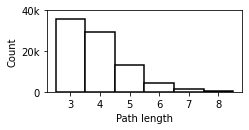

In [ ]:
plt.figure(figsize=[3.5, 1.5])
plt.hist(datamodule.dataset.raw_data['path_length'], bins=np.arange(3,10)-0.5, rwidth=1, color='white', edgecolor='black', linewidth=1.5)
# plt.yticks([0,10000,20000,30000,40000], labels=['0','10k','20k','30k','40k'])
plt.yticks([0,20000,40000], labels=['0','20k','40k'])
# plt.yticks([0,3000,6000], labels=['0','3k','6k'])
plt.xticks(range(3,9))
plt.xlabel('Path length')
plt.ylabel('Count')
# plt.savefig('../figure/plos/random50_path_length_distribution.png', dpi=300, bbox_inches='tight')

#### metrics over learning

In [4]:
for runid in ['2re0wt2b', '1chrs9j0', '158q4p5u', '63zgwwtq']:
    print(runid)
    config = get_config(runid)
    root = config['wandb']['save_dir'] + config['wandb']['project']
    ckpts = utils.load.get_ckptfs_from_run(root, runid)
    init_ckpt = f'{root}/{runid}/checkpoints/init.ckpt'
    ckpts = pd.concat([pd.DataFrame({'epoch':[0], 'step':[0], 'fname':[init_ckpt]}), ckpts])
    ckpts.shape

    val_batch = 'len4+'
    model, datamodule, batch = utils.load.load_model_and_val_batch(config=config, ckpt_dir=f'{root}/{runid}/checkpoints', ckpt='last', val_batch=val_batch)
    batch_metadata = utils.analysis.generate_batch_metadata(dm=datamodule, batch=batch)

    if os.path.exists(f'../figure/plot_data/v4/beh_results_{val_batch}_over_ckpts_{runid}.pkl'):
        beh_results_over_ckpts = pkl.load(open(f'../figure/plot_data/v4/beh_results_{val_batch}_over_ckpts_{runid}.pkl', 'rb'))
    else:
        beh_results_over_ckpts = defaultdict(list)

    # for i, row in ckpts.iterrows():
    # for i, row in pd.concat([ckpts[:20], ckpts[20:200:18], ckpts[200::20]]).iterrows(): # human30
    # for i, row in pd.concat([ckpts[:50:2], ckpts[50:100:10], ckpts[100::100]]).iterrows(): # human30filler
    for i, row in pd.concat([ckpts[:120:6], ckpts[120:500:38], ckpts[500::500]]).iterrows(): # random50

        if row.step in beh_results_over_ckpts['step']: continue
        print(row.step, end=', ')
        beh_results_over_ckpts['step'].append(row.step)

        model = GraphModelModule.load_from_checkpoint(row.fname)
        _ = model.eval()
        
        predictions = model_eval(model, datamodule, device='cuda:8', fname=None)
        acc_result = utils.analysis.accuracy_profile(predictions, batch, batch_metadata, verbose=False)
        pathpref_result = utils.analysis.path_preference(predictions, batch, batch_metadata, verbose=False)
        pathreg_result = utils.analysis.path_choice_regression(batch, model, predictions, batch_metadata=batch_metadata, 
                                                               path_score='avg', response='binary', verbose=False)
        result = acc_result | pathpref_result | pathreg_result
        for k in result:
            if k == 'acc': continue
            beh_results_over_ckpts[k].append(result[k])

        # pkl.dump(beh_results_over_ckpts, open(f'../figure/plot_data/v4/beh_results_{val_batch}_over_ckpts_{runid}.pkl', 'wb'))

2re0wt2b
1461, 1712, 1952, 2203, 2443, 2694, 2934, 3185, 3425, 3676, 3916, 4167, 4407, 4658, 4898, 6462, 8015, 9568, 11121, 12674, 14227, 15791, 17344, 18897, 20450, 40912, 61363, 81825, 102287, 122738, 143200, 163662, 184113, 1chrs9j0
0, 239, 479, 730, 970, 1221, 1461, 1712, 1952, 2203, 2443, 2694, 2934, 3185, 3425, 3676, 3916, 4167, 4407, 4658, 4898, 6462, 8015, 9568, 11121, 12674, 14227, 15791, 17344, 18897, 20450, 40912, 61363, 81825, 102287, 122738, 143200, 163662, 184113, 158q4p5u
0, 239, 479, 730, 970, 1221, 1461, 1712, 1952, 2203, 2443, 2694, 2934, 3185, 3425, 3676, 3916, 4167, 4407, 4658, 4898, 6462, 8015, 9568, 11121, 12674, 14227, 15791, 17344, 18897, 20450, 40912, 61363, 81825, 102287, 122738, 143200, 163662, 184113, 63zgwwtq
0, 239, 479, 730, 970, 1221, 1461, 1712, 1952, 2203, 2443, 2694, 2934, 3185, 3425, 3676, 3916, 4167, 4407, 4658, 4898, 6462, 8015, 9568, 11121, 12674, 14227, 15791, 17344, 18897, 20450, 40912, 61363, 81825, 102287, 122738, 143200, 163662, 184113, 

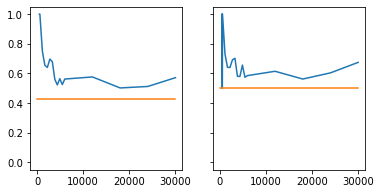

In [6]:
fig, axes = plt.subplots(1, 2, figsize=[6,3], sharex=True, sharey=True)
axes[0].plot(beh_results_over_ckpts['step'], beh_results_over_ckpts['BCpref'])
axes[0].plot(beh_results_over_ckpts['step'], beh_results_over_ckpts['BC_baseline'])
axes[1].plot(beh_results_over_ckpts['step'], beh_results_over_ckpts['DCpref'])
axes[1].plot(beh_results_over_ckpts['step'], beh_results_over_ckpts['DC_baseline'])

### across multiple runs

In [6]:
sheet_id = '1nFaMtdoecqKbtQyNvZ-xFQGpV6j0nfqhxCZJMEnRs_I'
gid = '299429988'
experiment_log = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?gid={gid}&format=csv')
experiment_log['project phase'] = pd.Series(experiment_log['project phase']).fillna(method='ffill')

In [7]:
experiment_log

,project phase,runid,model type,architecture,note,wandb link,git hash,dataset,data split,embed dim
0,edge token models,2xzf7b0b,random-masked,L1H1,NaN,random50_50x10-split_by_graph-randommasked_edg...,NaN,random50,by_graph,256
1,edge token models,1019r4sk,random-masked,L1H1,NaN,random50_50x10-split_by_graph-randommasked_edg...,NaN,random50,by_graph,256
2,edge token models,2p0kzl0n,random-masked,L1H1,NaN,random50_50x10-split_by_graph-randommasked_edg...,NaN,random50,by_graph,256
3,edge token models,1irz3l4a,random-masked,L1H1,NaN,random50_50x10-split_by_graph-randommasked_edg...,NaN,random50,by_graph,256
4,edge token models,28qir0bf,random-masked,L1H1,NaN,human30_30x10-split_by_graph-randommasked_edge...,NaN,human30,by_graph,256
5,edge token models,fqww4ieg,random-masked,L1H1,NaN,human30_30x10-split_by_graph-randommasked_edge...,NaN,human30,by_graph,256
6,edge token models,3aro8ucy,random-masked,L1H1,NaN,human30_30x10-split_by_graph-randommasked_edge...,NaN,human30,by_graph,256
7,edge token models,3ufgfhr2,random-masked,L1H1,NaN,human30_30x10-split_by_graph-randommasked_edge...,NaN,human30,by_graph,256
8,edge token models,2j5zdp1n,autoreg,L2H1,NaN,random50_50x10-split_by_graph-autoreg_edgetoke...,NaN,random50,by_graph,256
9,edge token models,16jz2c0j,autoreg,L2H1,NaN,random50_50x10-split_by_graph-autoreg_edgetoke...,NaN,random50,by_graph,256


#### end accuracy, path pref, and path regression

In [8]:
runs = experiment_log[experiment_log['project phase'].str.contains('edge token')]
runs = runs[['project phase', 'runid', 'model type', 'architecture', 'dataset']]

In [9]:
runs

,project phase,runid,model type,architecture,dataset
0,edge token models,2xzf7b0b,random-masked,L1H1,random50
1,edge token models,1019r4sk,random-masked,L1H1,random50
2,edge token models,2p0kzl0n,random-masked,L1H1,random50
3,edge token models,1irz3l4a,random-masked,L1H1,random50
4,edge token models,28qir0bf,random-masked,L1H1,human30
5,edge token models,fqww4ieg,random-masked,L1H1,human30
6,edge token models,3aro8ucy,random-masked,L1H1,human30
7,edge token models,3ufgfhr2,random-masked,L1H1,human30
8,edge token models,2j5zdp1n,autoreg,L2H1,random50
9,edge token models,16jz2c0j,autoreg,L2H1,random50


In [23]:
results = {}
for runid in ['2xzf7b0b', '1019r4sk', '2p0kzl0n', '1irz3l4a']:
    print(runid, end=', ')
    config = get_config(runid)
    root = config['wandb']['save_dir'] + config['wandb']['project']
    model, datamodule, batch = utils.load.load_model_and_val_batch(config=config, ckpt_dir=f'{root}/{runid}/checkpoints', ckpt='last', val_batch='len4+')
    batch_metadata = utils.analysis.generate_batch_metadata(dm=datamodule, batch=batch)
    if type(model.transformer) is GraphRandomMaskedTransformer:
        predictions = pkl.load(open(f'{root}/{runid}/final_eval_max_negent.pkl', 'rb'))
    else:
        predictions = pkl.load(open(f'{root}/{runid}/final_eval.pkl', 'rb'))

    acc_result = utils.analysis.accuracy_profile(predictions, batch, batch_metadata, verbose=False)
    pathpref_result = utils.analysis.path_preference(predictions, batch, batch_metadata, verbose=False)
    pathreg_result = utils.analysis.path_choice_regression(batch, model, predictions, batch_metadata=batch_metadata, 
                                                            path_score='avg', response='binary', verbose=False)
    results[runid] = acc_result | pathpref_result | pathreg_result

2xzf7b0b, 1019r4sk, 2p0kzl0n, 1irz3l4a, 

In [24]:
model_type = 'random-masked'
dataset = 'random50'

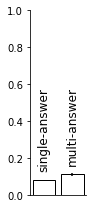

In [ ]:
# plot accuracies of last.ckpt

runids = runs[(runs['project phase'].str.contains('edge token')) & (runs['model type']==model_type) & (runs['dataset']==dataset)]['runid'].values

fig, ax = plt.subplots(1, 1, figsize=[1.4,3])

values = np.array([[results[runid]['sa acc'] for runid in runids], [results[runid]['ma acc'] for runid in runids]])
ax.bar([0,1], values.mean(1), color='white', edgecolor='black')
ax.errorbar([0,1], values.mean(1), yerr=values.std(1), fmt='none', color='black')

for i, col in enumerate(['single-answer', 'multi-answer']):
    ax.text(i, values.mean(1)[i]+0.05, col, rotation='vertical', fontsize=12, horizontalalignment='center', verticalalignment='bottom')
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(0,1.0)
fig.tight_layout()
# fig.savefig(f'../figure/plos/seqacc_{dataset}_edgetoken_{model_type}.png', dpi=300)

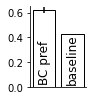

In [ ]:
# path preference

runids = runs[(runs['project phase'].str.contains('edge token')) & (runs['model type']==model_type) & (runs['dataset']==dataset)]['runid'].values

fig, ax = plt.subplots(1, 1, figsize=[1.4,1.5])

values = np.array([[results[runid]['BCpref'] for runid in runids], [results[runid]['BC_baseline'] for runid in runids]])
ax.bar([0,1], values.mean(1), color='white', edgecolor='black')
ax.errorbar([0,1], values.mean(1), yerr=values.std(1), fmt='none', color='black')

for i, col in enumerate(['BC pref', 'baseline']):
    ax.text(i, 0.02, col, rotation='vertical', fontsize=12, horizontalalignment='center', verticalalignment='bottom')
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(0,0.65)
# ax.set_yticks([0, 0.2, 0.4, 0.6])
fig.tight_layout()
# fig.savefig(f'../figure/plos/pathpref_{dataset}_edgetoken_{model_type}.png', dpi=300)

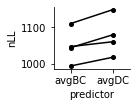

In [ ]:
# path regression
runids = runs[(runs['project phase'].str.contains('edge token')) & (runs['model type']==model_type) & (runs['dataset']==dataset)]['runid'].values

fig, ax = plt.subplots(1, 1, figsize=[2,1.6])
for runid in runids:
    values = [results[runid]['n_samples']*results[runid]['log_BC'], results[runid]['n_samples']*results[runid]['log_DC']]
    ax.plot(['avgBC', 'avgDC'], values, color='black', marker='o', ms=4)

ax.set_xlim(-0.4,1.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylim(0.645, 0.675)
ax.set_xlabel('predictor')
ax.set_ylabel('nLL')
fig.tight_layout()
# fig.savefig(f'../figure/plos/pathreg_edgetoken_{dataset}_{model_type}.png', dpi=300, bbox_inches='tight')

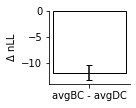

In [85]:
# path regression alt plot
runids = runs[(runs['project phase'].str.contains('graph context')) & (runs['model type']=='autoreg') & (runs['dataset']=='human30')]['runid'].values

fig, ax = plt.subplots(1, 1, figsize=[2,1.6])
values = [
    results[runid]['n_samples']*results[runid]['log_BC'] - results[runid]['n_samples']*results[runid]['log_DC']
    for runid in runids
]
ax.bar(0, np.mean(values), color='white', edgecolor='black', linewidth=1)
ax.errorbar(0, np.mean(values), yerr=sp.stats.sem(values), fmt='none', color='black', capsize=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0])
ax.set_xticklabels(['avgBC - avgDC'])
ax.set_ylabel('Δ nLL')
fig.tight_layout()

#### path pref over learning

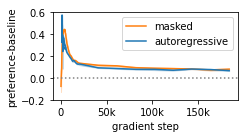

In [ ]:
# groups = {
#     'autoregressive': ['k2x2f9gm', '1wczubuv', '2u8z8nk4', '2w5wl65b'], # human30-autoreg
#     'masked': ['hfuz3w12', '2eogdrwq', '258zf14v', '13e7b8ig'], # human30-randmasked
#     'autoregressive-filler': ['1lxqgpz2', '1m13lric', '1elk6spd', 'niy6sfzp'] # human30-autoreg-filler
# }
groups = {
    'autoregressive': ['2re0wt2b', '1chrs9j0', '158q4p5u', '63zgwwtq'], # random50-autoreg
    'masked': ['1sbzhmry', '17lwle4y', '3hblx7rk', 'k5t3el7a'] # random50-randmasked
}

fig, ax = plt.subplots(1, 1, figsize=[3.5,2], sharex=True)

values = defaultdict(list)
for i, model_type in enumerate(reversed(groups)):
    values = defaultdict(list)
    for runid in groups[model_type]:
        if model_type in ['autoregressive', 'autoregressive-filler']:
            x = pkl.load(open(f'../figure/plot_data/v4/beh_results_len4+_over_ckpts_{runid}.pkl', 'rb'))
        elif model_type == 'masked':
            x = pkl.load(open(f'../figure/plot_data/v4/beh_results_len4+_over_ckpts_{runid}_max_negent.pkl', 'rb'))
        for k in ['step', 'BCpref', 'BC_baseline', 'log_BC', 'log_DC', 'bayes_factor (BC/DC)']:
            values[k].append(x[k])
    values = {k: np.array(values[k], dtype=np.float) for k in values}

    color = f'C{len(groups)-1-i}'
    utils.plot.plot_line_and_ribbon(ax, values['step'].mean(0), values['BCpref'] - values['BC_baseline'], 
                                    color=color, label=model_type)

# handles, labels = ax.get_legend_handles_labels()
# order = [2,1,0]
# ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

ax.legend()
ax.set_xlabel('gradient step')
# ax.set_xticks([0, 10000, 20000,30000])
# ax.set_xticklabels(['0','10k','20k','30k'])
ax.set_xticks([0, 50000, 100000, 150000])
ax.set_xticklabels(['0','50k','100k','150k'])
ax.set_ylabel('preference-baseline')
ax.set_ylim([-0.2, 0.6])
ax.axhline(y=0, color='gray', linestyle=':')

fig.tight_layout()
# fig.savefig(f'../figure/plos/random50_path_pref_learning.png', dpi=300, bbox_inches='tight')

#### masked model node prediction order

In [308]:
# pull results
result = []
for runid in ['1sbzhmry', '17lwle4y', '3hblx7rk', 'k5t3el7a']:
    df = pd.read_csv(f'{root}/{runid}/pred_order_max_negent.csv')
    result.append(df)
result = pd.concat(result)

In [312]:
runid = '17lwle4y'
config = get_config(runid)
root = config['wandb']['save_dir'] + config['wandb']['project']
model, datamodule, batch = utils.load.load_model_and_val_batch(config=config, ckpt_dir=f'{root}/{runid}/checkpoints', ckpt='last', val_batch='len4+')
batch_metadata = utils.analysis.generate_batch_metadata(dm=datamodule, batch=batch)

In [313]:
result[(result['runid']==runid)&(result['path_len']==8)]['probe'].drop_duplicates()[:20].values

array([11950, 12426, 12646, 12774, 13122, 13470, 15687, 15768, 15863,
       16115, 16296, 16648, 33896, 35370, 35710, 36220, 46983, 47436,
       47663, 48286])

start=3, goal=6
[[3, 14, 7, 5, 13, 2, 4, 6], [3, 11, 10, 5, 13, 2, 4, 6]]
seq correct=True , model pred node:  [(1, 11), (0, 10), (2, 5), (5, 13), (4, 2), (3, 4)]


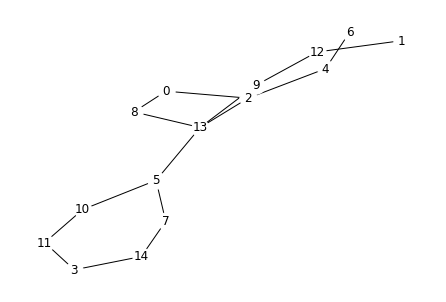

In [314]:
probe = 16115
batch_i = batch['index'].tolist().index(probe)
edge_list = batch['edges'][batch_i]
edge_list = edge_list[edge_list[:,0]!=model.transformer.node_embeddings.padding_idx].tolist() # remove padded edge and turn into list
nx.draw(nx.Graph(edge_list), with_labels=True, node_color='white')
s, g = batch['start_goal_probe'][batch_i]
print(f'start={s}, goal={g}')
print(datamodule.dataset.raw_data['shortest_path'][probe])

pred = result[(result['runid']==runid)&(result['probe']==probe)]
print('seq correct='+str(pred['seq_correct'].values[0]), ', model pred node: ', list(zip(pred['pred_order'], pred['pred_node'])))

In [309]:
# removes 5% of data on human30, 34% on random50 
# (mostly because iterative generation hurts fullymasked models)
result = result[result['seq_correct']]

In [310]:
agg_result = result.drop(['graph_context', 'probe', 'seq_correct'], axis=1)
agg_result = agg_result.groupby(['model_type', 'runid', 'path_len', 'pred_order', 'iterative_mode']).mean().reset_index()
agg_result = agg_result.groupby(['model_type', 'path_len', 'pred_order', 'iterative_mode']).agg([np.mean, np.std]).reset_index()

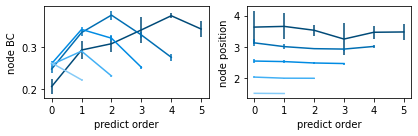

In [311]:
fig, axes = plt.subplots(1, 2, figsize=[6,2], sharex=True)
colors = {4:'#86cbf7', 5: '#42b0f5', 6: '#008be3', 7:'#006eb3', 8:'#004a78'}

plot_data = agg_result[agg_result['model_type']=='random-masked']

for i, diag_prop in enumerate(['node_BC', 'node_pos']):
    ax = axes[i]
    for l in reversed(plot_data['path_len'].unique()):
        x = plot_data[(plot_data['path_len']==l)]
        ax.errorbar(x['pred_order'], x[diag_prop]['mean'], x[diag_prop]['std'], 
                    color=colors[l], label=f'{l}')

axes[0].set_ylabel('node BC')
axes[1].set_ylabel('node position')
axes[0].set_xlabel('predict order')
axes[1].set_xlabel('predict order')
axes[0].set_xticks(range(4) if dataset == 'human30' else range(6))
# axes[1].legend(loc='lower right', framealpha=0.5, ncol=2)

fig.tight_layout()
# fig.savefig(f'../figure/ccn24/poster/{dataset}_iterative_node_pred_order.pdf')

#### masked model node certainty

In [316]:
def quick_node_certainty_eval(model, test_batch, datamodule, batch_metadata):

    def forward_once(model, batch, mask_all):
        assert type(model) is GraphModelModule
        model.transformer.mask_all = mask_all
        x = utils.analysis.run_model_over_batch(batch, model, config['model']['type'], datamodule.dataset.raw_data['shortest_path'])
        correct, pred_paths, closest_target, attn_weights, token_reps = x
        target_nodes = model.transformer.batch_output_mask
        return correct, pred_paths, target_nodes

    # get baseline forward once results
    # TODO: forward_once expects the model as a model module, need to fix
    correct, pred_paths, target_nodes = forward_once(model, test_batch, mask_all=True)
    forward_once_acc = correct.float().mean().item()
    model = model.transformer

    out_probs = F.softmax(model(test_batch)[:, -model.max_path_len:, :], dim=-1)
    out_probs.masked_fill_(~model.batch_output_mask.unsqueeze(-1), 0.0) # zero out output prob dist at non-intemediate nodes
    node_sumprobs = out_probs.sum(1) # (bsz, n_node), summed prob across intermediate positions for each node

    n_node = node_sumprobs.shape[-1]
    df = defaultdict(list)
    # df columns probe, start, goal, node, node_bc, node_sumprob
    for batch_i, probe in enumerate(test_batch['index']):
        probe = probe.item()
        path_len = test_batch['path_len'][batch_i].item()
        start, goal = test_batch['start_goal_probe'][batch_i].tolist()
        nodes = list(range(n_node))
        node_sumprob = node_sumprobs[batch_i].tolist()

        df['probe'].extend([probe]*len(nodes))
        df['path_len'].extend([path_len]*len(nodes))
        df['start'].extend([start]*len(nodes))
        df['goal'].extend([goal]*len(nodes))
        df['node'].extend(nodes)
        df['node_sumprob'].extend(node_sumprob)
        df['node_BC'].extend([batch_metadata['graph_BC_scores'][probe][n] for n in nodes])
        df['node_DC'].extend([batch_metadata['graph_DC_scores'][probe][n] for n in nodes])
    df = pd.DataFrame(df)

    node_sumprob_bc_corr = sp.stats.pearsonr(df['node_sumprob'], df['node_BC'])
    # accuracy of top n_intermediate nodes
    df = df.sort_values(by=['probe', 'node_sumprob']) # small to large
    df['rank'] = np.tile(list(reversed(range(n_node))), len(test_batch['index']))
    # probability of start or goal should always be low
    start_goal_rank = df[(df['start']==df['node'])|(df['goal']==df['node'])]['rank'].mean()

    topn = df[df['rank'] < df['path_len']-2] # top n nodes
    correct = []
    match_forward_once = []
    for i, p in enumerate(test_batch['index']):
        p = p.item()
        topn_nodes = topn[topn['probe']==p]['node'].tolist()
        paths = datamodule.dataset.raw_data['shortest_path'][p]
        match = [set(topn_nodes)==set(path[1:-1]) for path in paths]
        correct.append(max(match))

        fullmask_pred_nodes = pred_paths[i][target_nodes[i]]
        match_forward_once.append(set(topn_nodes)==set(fullmask_pred_nodes.tolist()))
    print('topn match with forward_once: ', np.mean(match_forward_once))
    df['correct'] = [correct[test_batch['index'].tolist().index(p)] for p in df['probe']]

    return df, {'node_sumprob_bc_corr': node_sumprob_bc_corr, 
                'start_goal_rank': start_goal_rank,
                'forward_once_acc': forward_once_acc,
                'topn_acc': np.mean(correct)
                }

In [318]:
all_dfs = []
agg_result = defaultdict(list)
for runid in ['1sbzhmry', '17lwle4y', '3hblx7rk', 'k5t3el7a']:
    config = get_config(runid)
    root = config['wandb']['save_dir'] + config['wandb']['project']
    model, datamodule, batch = utils.load.load_model_and_val_batch(config=config, ckpt_dir=f'{root}/{runid}/checkpoints', ckpt='last', val_batch='len4+')
    batch_metadata = utils.analysis.generate_batch_metadata(dm=datamodule, batch=batch)

    test_batch = {k:batch[k] for k in batch}
    test_batch_metadata = utils.analysis.generate_batch_metadata(dm=datamodule, batch=test_batch)
    df, values = quick_node_certainty_eval(model, test_batch, datamodule, batch_metadata)
    df['runid'] = runid
    all_dfs.append(df)

    top1_nodes = df[df['rank']==0]['node'].values
    max_negent_pred_order = pd.read_csv(f'{root}/{runid}/pred_order_max_negent.csv')
    max_negent_nodes = max_negent_pred_order[max_negent_pred_order['pred_order']==0]['pred_node'].values
    print('top1_match_max_negent: ', (top1_nodes == max_negent_nodes).mean())

    for k in values:
        agg_result[k].append(values[k])
df = pd.concat(all_dfs)

topn match with forward_once:  0.8906509465293923
top1_match_max_negent:  0.8325307206908004
topn match with forward_once:  0.8822255538897218
top1_match_max_negent:  0.8320006663334999
topn match with forward_once:  0.8735384360228875
top1_match_max_negent:  0.8164856124056721
topn match with forward_once:  0.8781193191208064
top1_match_max_negent:  0.8270533796066766


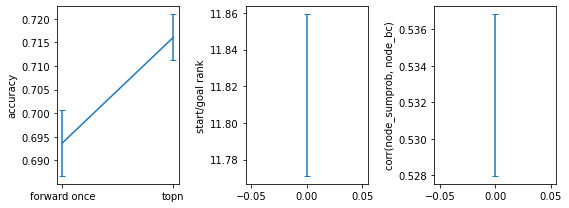

In [319]:
fig, axes = plt.subplots(1, 3, figsize=[8,3])

ax = axes[0]
ax.errorbar([0,1], y=[np.mean(agg_result['forward_once_acc']), np.mean(agg_result['topn_acc'])],
            yerr=[np.std(agg_result['forward_once_acc']), np.std(agg_result['topn_acc'])], capsize=3)
ax.set_ylabel('accuracy')
ax.set_xticks([0,1])
ax.set_xticklabels(['forward once', 'topn'])

ax = axes[1]
ax.errorbar(0, np.mean(agg_result['start_goal_rank']), yerr=np.std(agg_result['start_goal_rank']), capsize=3)
ax.set_ylabel('start/goal rank')

ax = axes[2]
coefs = [x[0] for x in agg_result['node_sumprob_bc_corr']]
ax.errorbar(0, np.mean(coefs), yerr=np.std(coefs), capsize=3)
ax.set_ylabel('corr(node_sumprob, node_bc)')

fig.tight_layout()

In [321]:
plot_data = df[df['correct']].groupby(['runid', 'path_len', 'rank']).mean().reset_index()
plot_data = plot_data.groupby(['path_len', 'rank']).agg([np.mean, np.std]).reset_index()

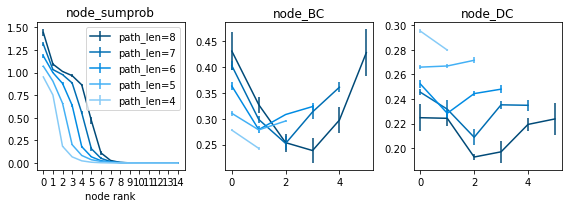

In [322]:
fig, axes = plt.subplots(1, 3, figsize=[8,3], sharex=False)
colors = {4:'#86cbf7', 5: '#42b0f5', 6: '#008be3', 7:'#006eb3', 8:'#004a78'}

for i, value in enumerate(['node_sumprob', 'node_BC', 'node_DC']):
    ax = axes[i]
    ax.set_title(value)
    for l in reversed(plot_data['path_len'].unique()):
        x = plot_data[plot_data['path_len']==l]
        if i > 0:
            x = x[x['rank']<l-2]
        ax.errorbar(x['rank'], x[value]['mean'], yerr=x[value]['std'], 
                    color=colors[l], label=f'path_len={l}')

axes[0].legend()
axes[0].set_xticks(range(15))
axes[0].set_xlabel('node rank')
fig.tight_layout()

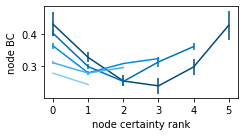

In [323]:
fig, ax = plt.subplots(1, 1, figsize=[3.5,2], sharex=False)
colors = {4:'#86cbf7', 5: '#42b0f5', 6: '#008be3', 7:'#006eb3', 8:'#004a78'}

value = 'node_BC'
for l in reversed(plot_data['path_len'].unique()):
    x = plot_data[plot_data['path_len']==l]
    if i > 0:
        x = x[x['rank']<l-2]
    ax.errorbar(x['rank'], x[value]['mean'], yerr=x[value]['std'], 
                color=colors[l], label=f'{l}')

# ax.legend(bbox_to_anchor=(1, 1), title='path length')
ax.set_xticks(range(6))
ax.set_xlabel('node certainty rank')
ax.set_ylabel('node BC')
fig.tight_layout()

# fig.savefig(f'../figure/ccn24/poster/{dataset}_iterative_node_certainty.pdf')